In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


На отдельно обработанных данных рассмотрим поездки из зоны с Empire State Building( границы: с -73.96668840000001 по -73.95557679999999 и 40.747766 по 40.756154200000005), с декабря 2015 по май 2016.

In [41]:
data = pd.read_csv('c6w3.csv', sep=';')
data.set_index('index', inplace = True)
data.head()

,su
index,
2015-12-01 00:00:00,10
2015-12-01 01:00:00,13
2015-12-01 02:00:00,0
2015-12-01 03:00:00,1
2015-12-01 04:00:00,5


Нарисуем график по подготовленным данным

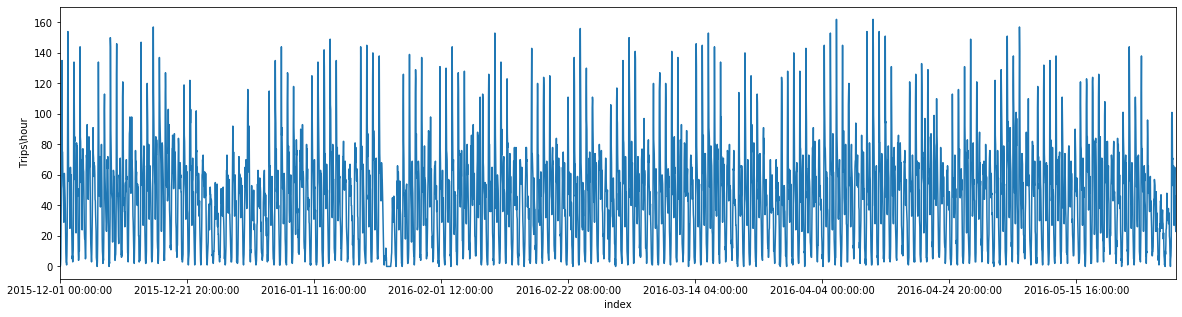

In [3]:
plt.figure(figsize(20,5))
data.su.plot()
plt.ylabel('Trips\hour')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда, дневная и недельная:

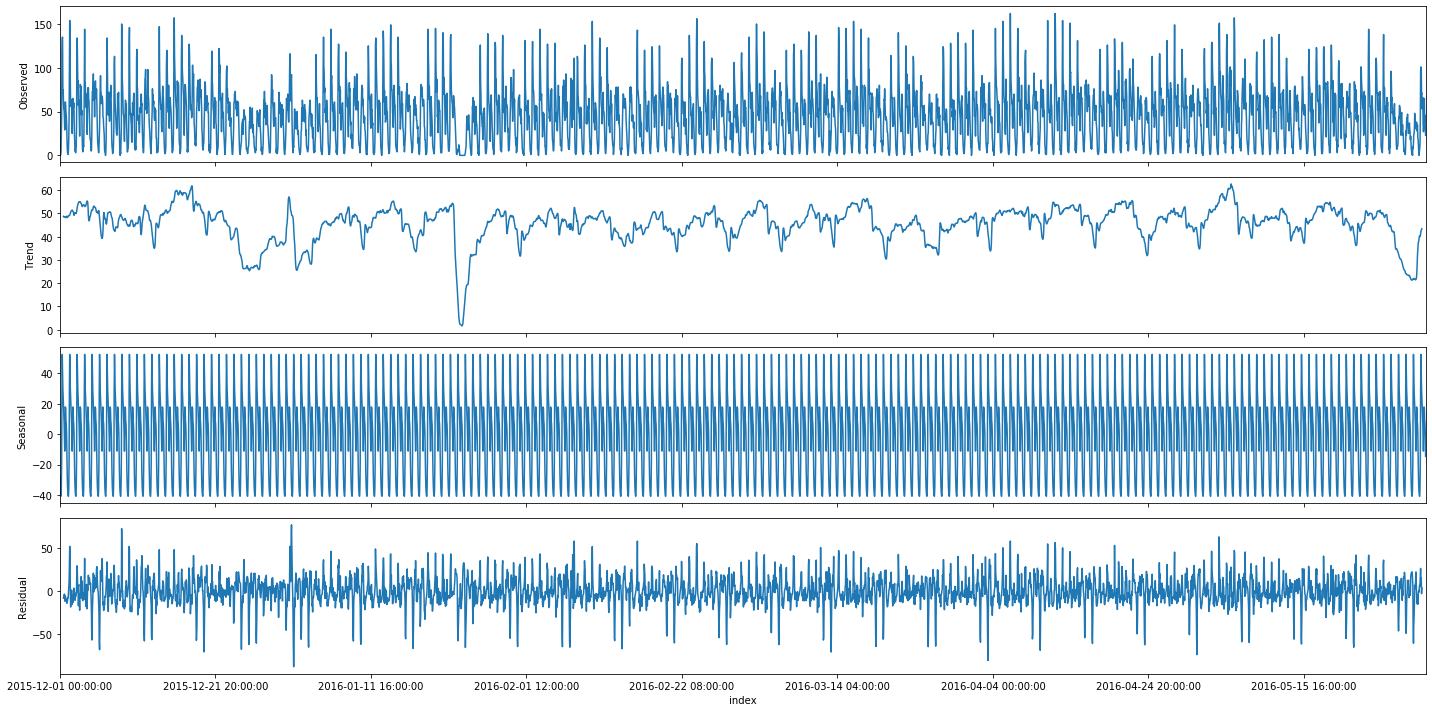

<Figure size 1440x720 with 0 Axes>

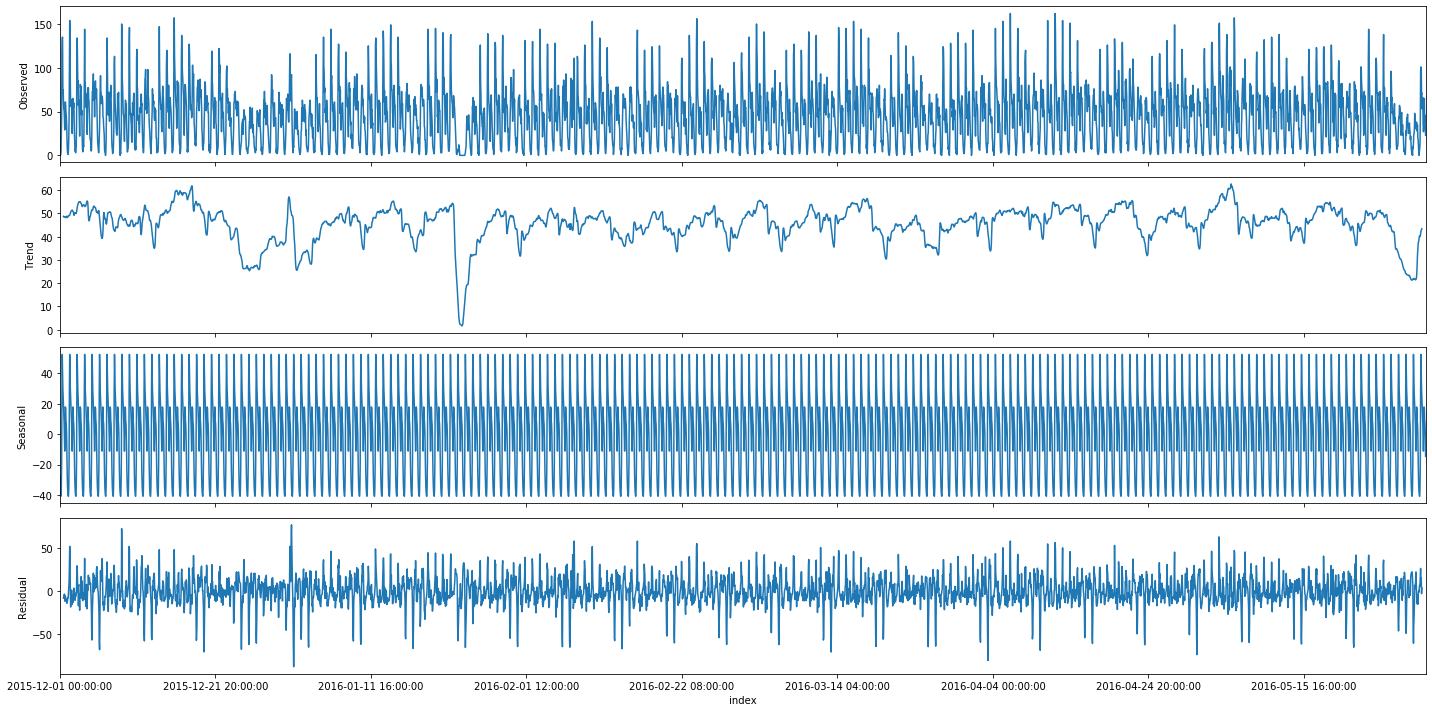

In [4]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data.su, freq= 24).plot()

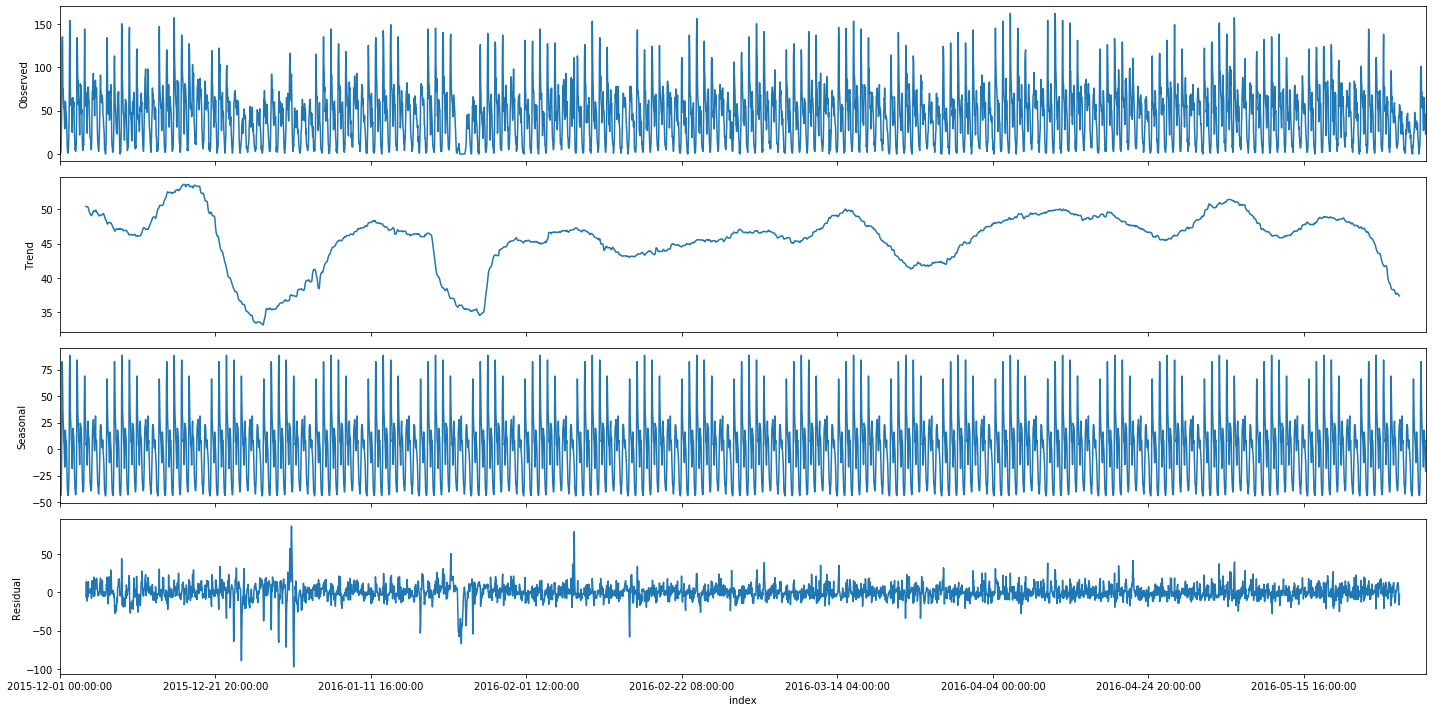

<Figure size 1440x720 with 0 Axes>

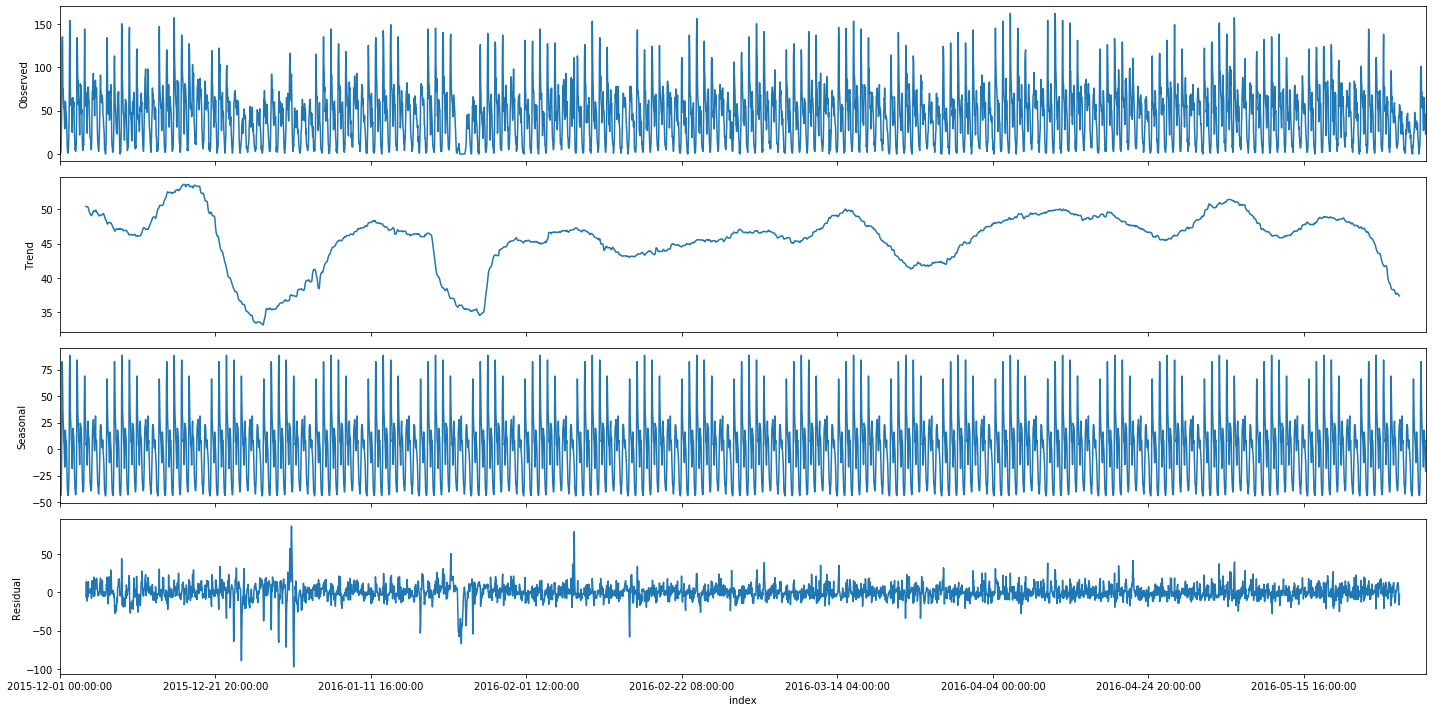

In [5]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data.su, freq= 168).plot()

Выбросы на графике обусловлены плохой погодой в приведенный период.

 Регрессия целового признака на построенные признаки с гиперпараметром К, как по условию.

In [6]:
%%time
k1= []
K = 140
for j in range (1, K+1):
    data1 = data.copy()
    for i in range(1, j+1):        
        data1['sin'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        data1['cos'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    y = data1.su
    X = data1.loc[:, 'sin1':]
    model = LinearRegression()
    stud = model.fit(X, y)
    k1.append(mean_squared_error(y, stud.predict(X)))
    K_opt = np.argmin(k1)
print ('Минимальное отклонение при K =', K_opt)

Минимальное отклонение при K = 139
Wall time: 25.4 s


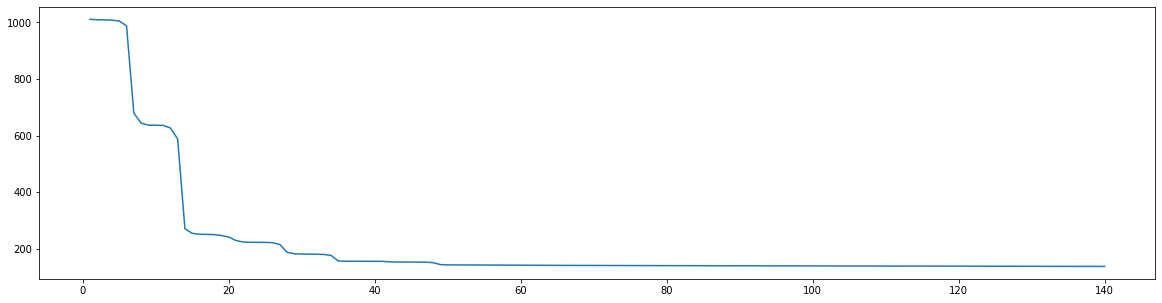

In [7]:
plt.figure(figsize(20, 5))
plt.plot(np.arange(1, K+1),k1)

По графику видно, что значение К выходит на оптимальный результат при примерно 50, и большее число брать нет смысла.

In [8]:
k1=50
for i in range(1, k1+1):        
        data['sin-'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        data['cos-'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)

Построим модель с оптимальным К.

In [9]:
y = data1.su
X_opt = data1.loc[:, 'sin1':]

model = LinearRegression()
stud = model.fit(X_opt, y)
y_pred = stud.predict(X_opt)

data['prediction'] = y_pred
data['error'] = y - y_pred

print ('Коэффициент детерминации модели:', stud.score(X_opt, y))

Коэффициент детерминации модели: 0.8654630321092134


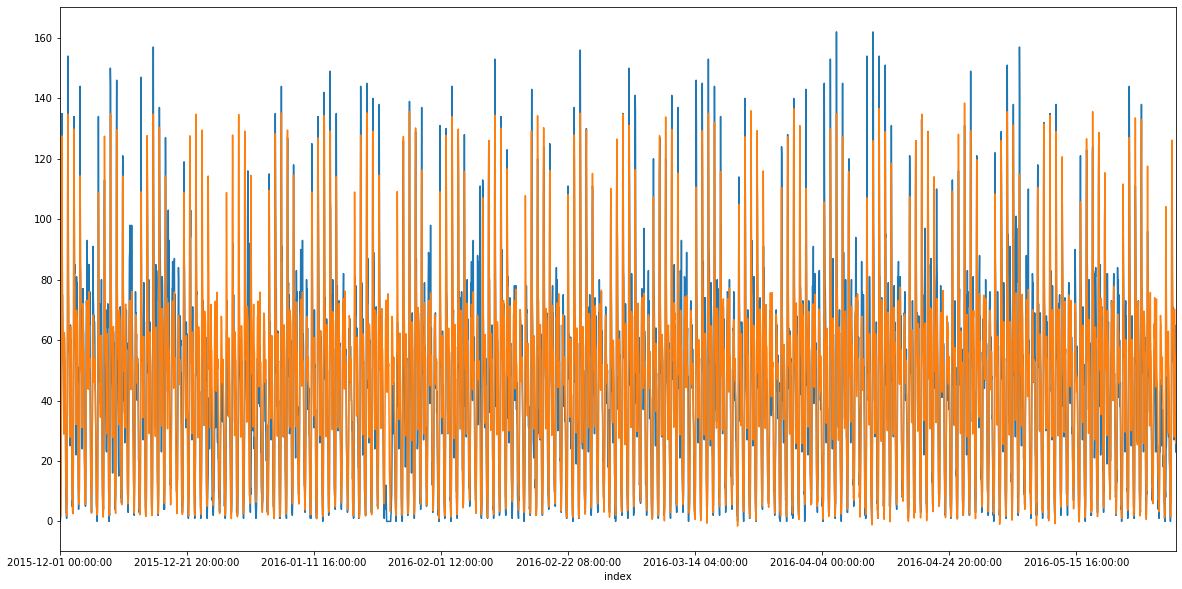

In [10]:
plt.figure(figsize(20, 10))
data['su'].plot()
data['prediction'].plot()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

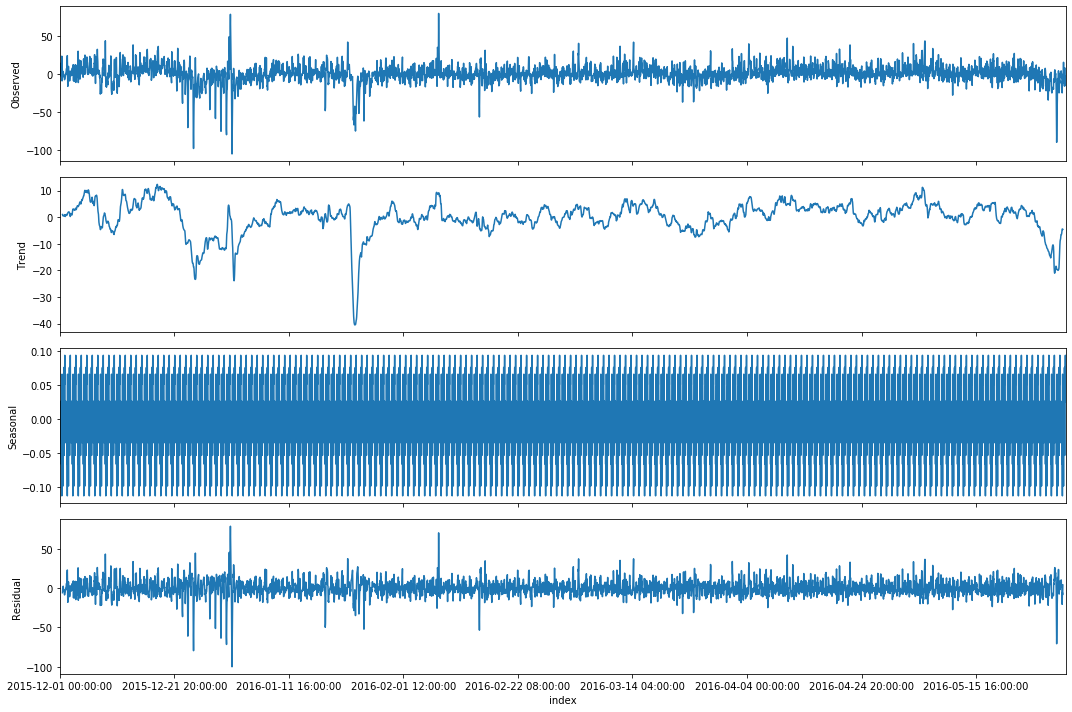

In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['error'], freq = 24).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['su'])[1])

Гипотеза нестационарности отвергается

Посмотрим на ACF и PACF полученного ряда:

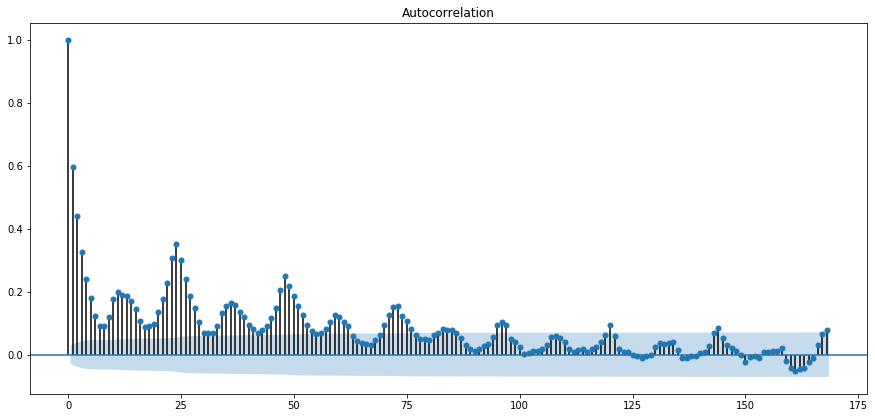

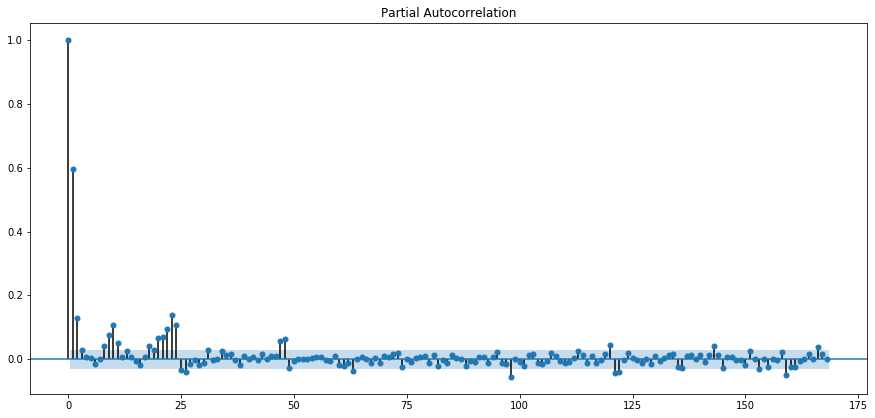

In [12]:
plt.figure(figsize(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['error'].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['error'].values.squeeze(), lags=168, ax=ax)
pylab.show()

 Выбранные значения параметров: Q = 1 q = 3 P = 2 p = 3

In [13]:
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['su'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12), initialization='approximate_diffuse').fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 59min 23s


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
89  (3, 2, 1, 2)  34643.676553
71  (2, 3, 1, 2)  34674.488139
83  (3, 1, 1, 2)  34726.404842
65  (2, 2, 1, 2)  34727.190776
95  (3, 3, 1, 2)  34729.471075


In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                 su   No. Observations:                 4392
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood              -17312.838
Date:                            Sun, 12 Jul 2020   AIC                          34643.677
Time:                                    14:50:38   BIC                          34701.138
Sample:                                12-01-2015   HQIC                         34663.952
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6494      0.022     76.703      0.000       1.607       1.692
ar.L2         -0.7560      0.029   

Смотрим остатки:

Критерий Стьюдента: p=0.962997
Критерий Дики-Фуллера: p=0.000000


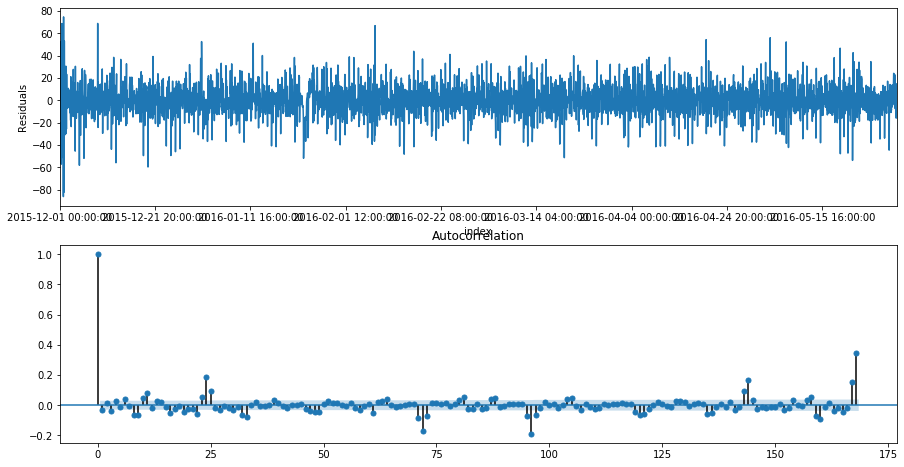

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Посмотрим, насколько хорошо модель описывает данные:

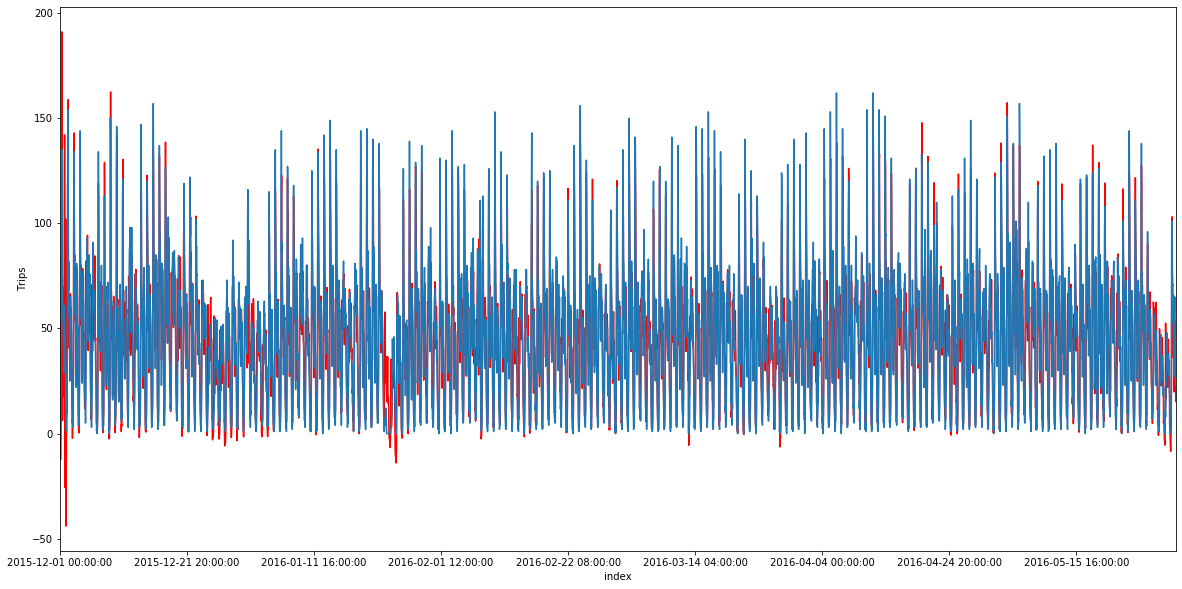

In [39]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(20,10))
data.model[:].plot(color='r')
data['su'].plot()
plt.ylabel('Trips')
pylab.show()

График очень подробный, визуально его сложно оценить. Для более точной оценки посмотрим предпоследний месяц, как себя ведут различные модели.

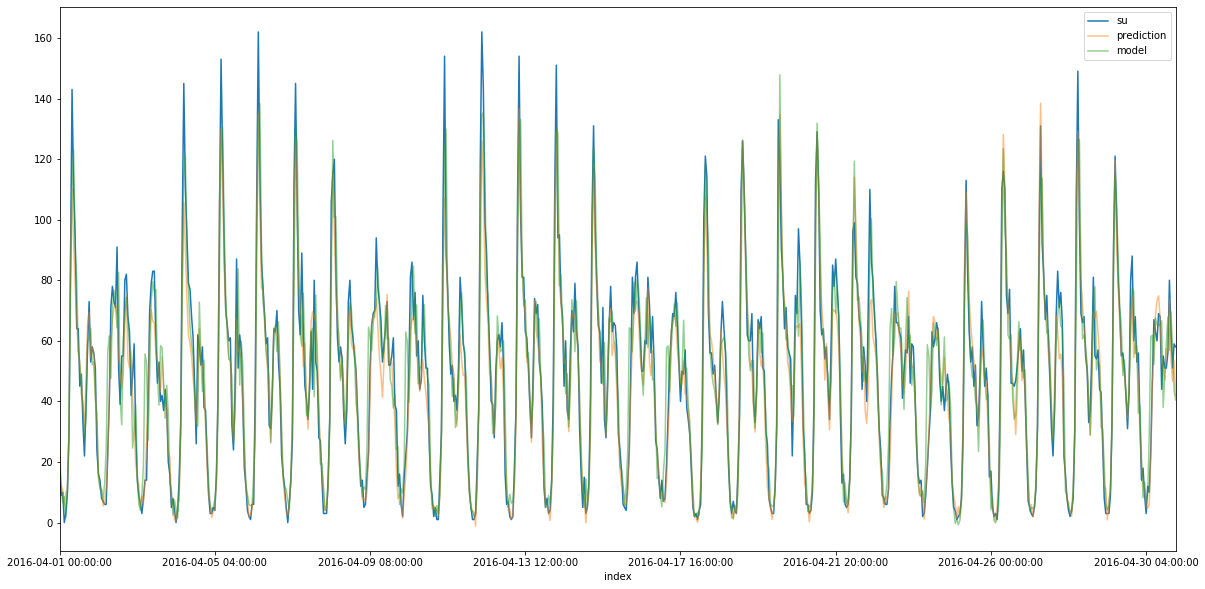

In [40]:
data.loc['2016-04-01 00:00:00':'2016-04-31 23:00:00','su'].plot(legend = True)
data.loc['2016-04-01 00:00:00':'2016-04-31 23:00:00','prediction'].plot(legend = True, alpha = 0.5)
data.loc['2016-04-01 00:00:00':'2016-04-31 23:00:00','model'].plot(legend = True, alpha = 0.5)

В итоге получается, что модель довольно хорошо описывает ряд, и более точно его прогнозирует, чем обычное предсказание, кроме случаев с внешним вмешательством (например, непогода в январе).